In [1]:
# 動かして学ぶAI・機械学習の基礎

In [ ]:
# 9章 シーケンスと時系列データの理解

In [2]:
#9.2 時系列を予測する技術

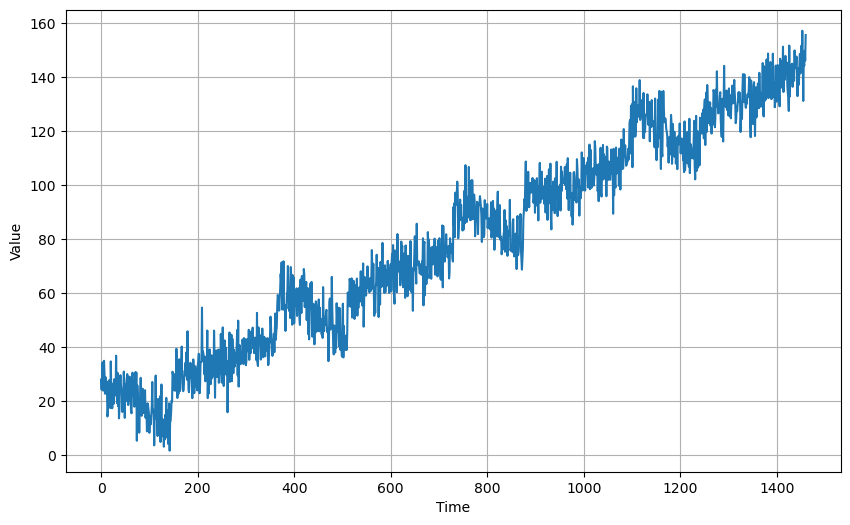

In [4]:
# native-forcast.ipynb
# トレンド・季節性・ノイズを持つ時系列の作成
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, .05)  
baseline = 10
amplitude = 15
slope = 0.09
noise_level = 6

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

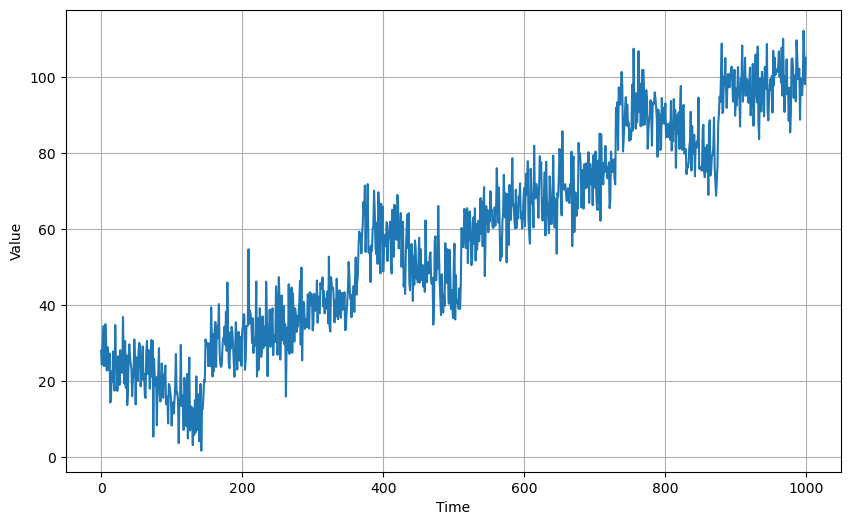

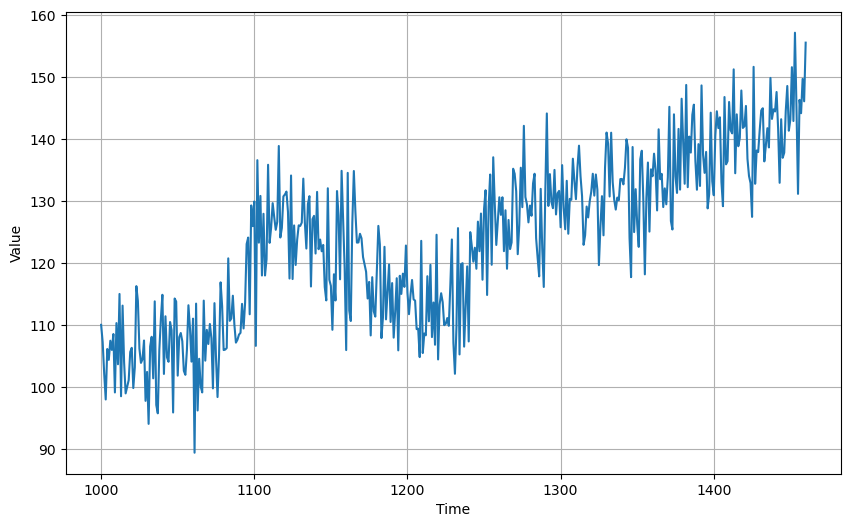

In [5]:
# タイムステップ1000までを学習セット、1000以降を検証セットとして分割
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train) # 学習セット
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid) # 検証セット
plt.show()

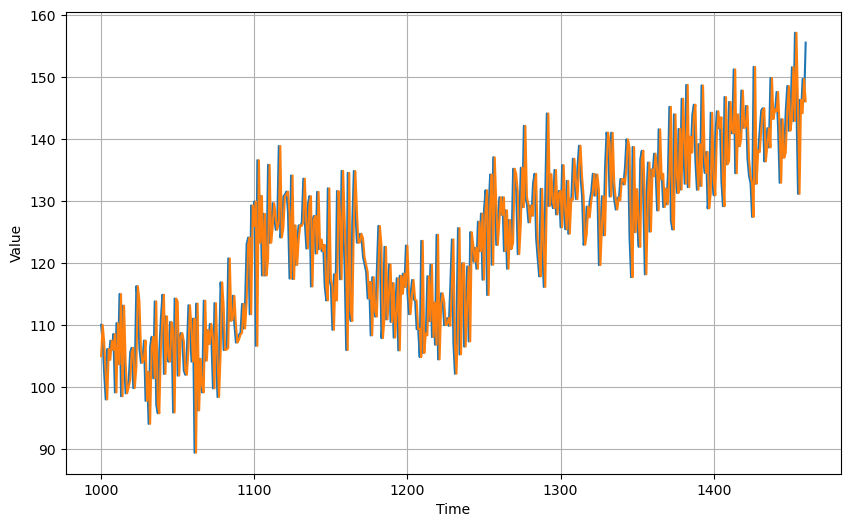

In [6]:
# 時刻tの値を時刻t+1の予測値にする(単純予測)
# 検証セットに単純予測を重ねたグラフを出力
naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

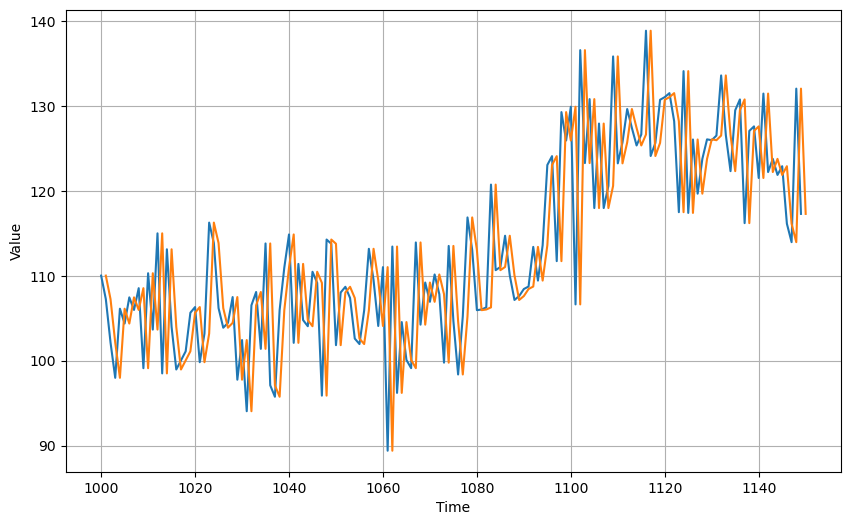

In [7]:
# 検証セット1001から1150までの拡大
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [8]:
# 予測正解率の測定
# MSE・・・時間tにおける予測値と実際の値の差を二乗して、平均を求める
# MAE・・・時間tにおける予測値と実際の値の差を計算し、その絶対値を求めることで負数を除去し、平均を求める

print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()) #MSE
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()) #MAE

76.47491
6.8992977


2022-12-01 19:03:12.665851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


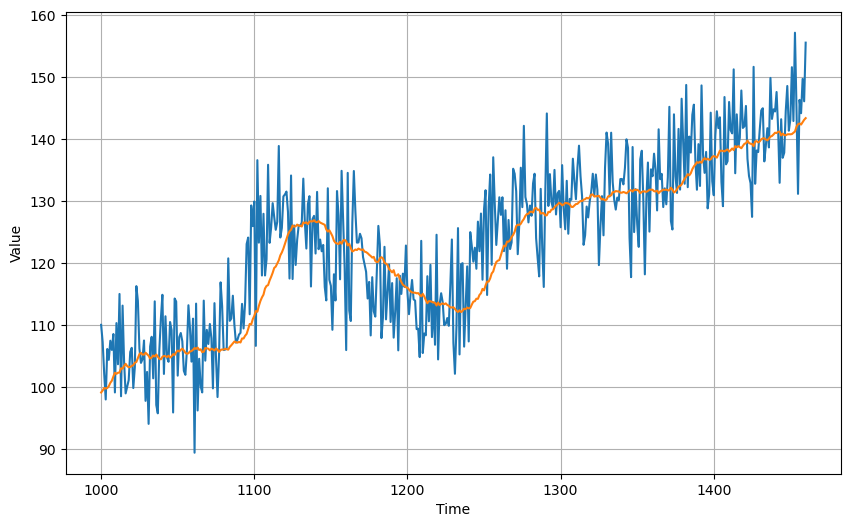

In [9]:
# 移動平均を使った予測
# 複数の値(例えば近傍の30個)を平均し、それをt時点の予測値とする

def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

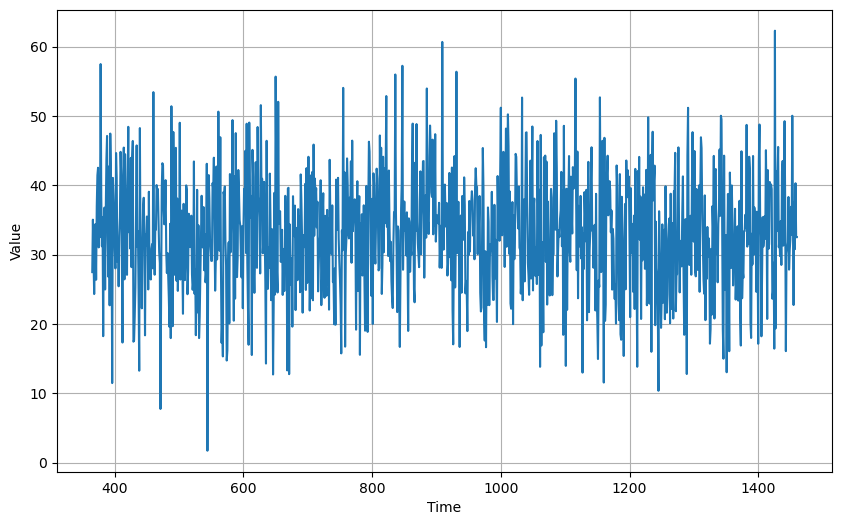

In [10]:
# 移動平均の改善
# この時系列の季節性が365日のため、差分法を用いてトレンドと季節性を平滑化する
# このアプローチでは、tの値からt-365の値を引くだけ

diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

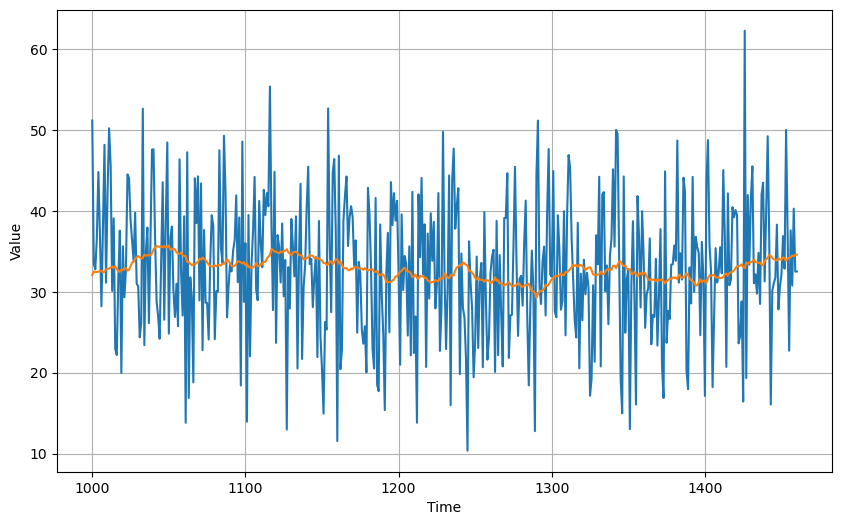

In [11]:
# 直前50セットの平均を予測値として用いる
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

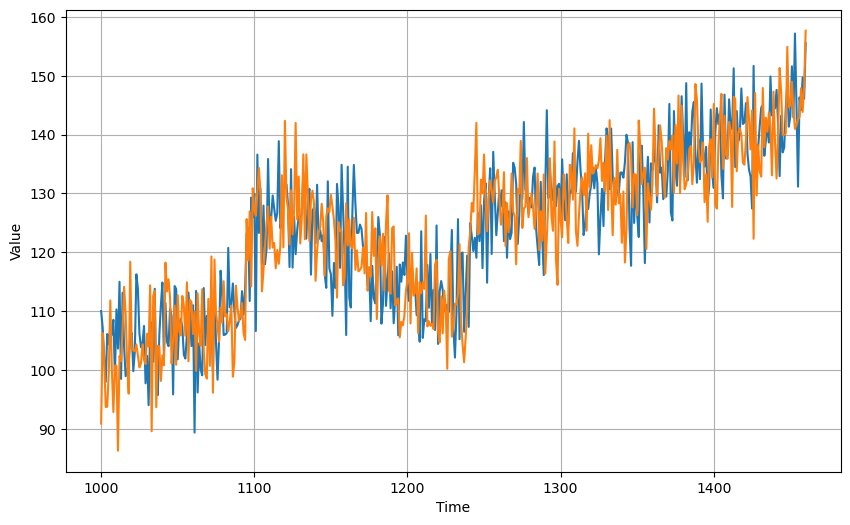

In [12]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [13]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

76.282074
7.0071726


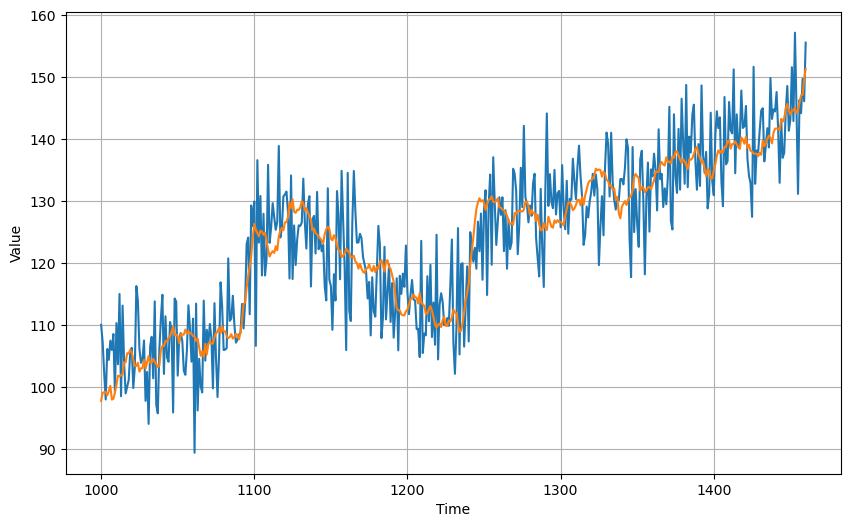

In [14]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [15]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

40.902336
5.136001


In [16]:
# 10章 シーケンスを予測するモデルの作成

In [17]:
# 10-1 ウィンドウデータセットの作成

In [18]:
# 0〜9の数値でできた基本的なデータセットを作成し、時系列をエミュレートする。
# 
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [19]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

# ウインドウ内の最初の4つの値を特徴量。後続の値をラベルとする。

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [20]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[5 6 7 8] [9]
[0 1 2 3] [4]
[1 2 3 4] [5]
[4 5 6 7] [8]
[3 4 5 6] [7]
[2 3 4 5] [6]


In [21]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[0 1 2 3]
 [5 6 7 8]]
y =  [[4]
 [9]]
x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]


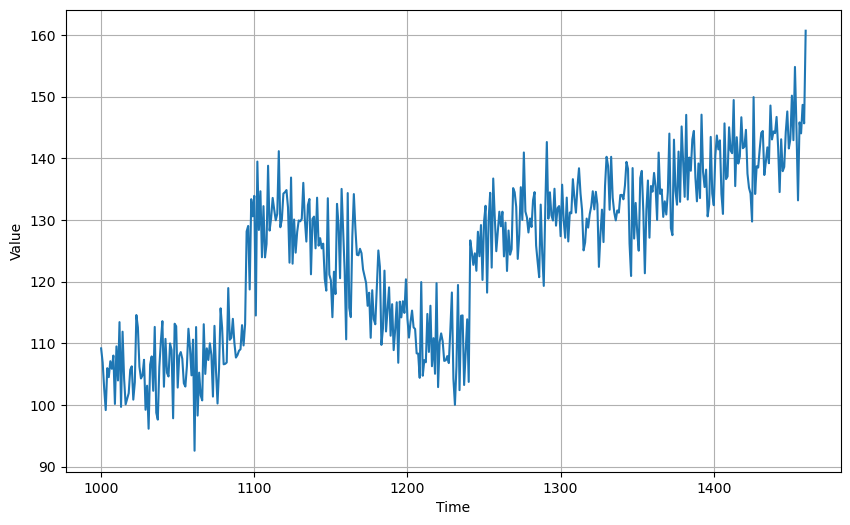

In [23]:
# 前章でも使用した時系列データセットを作成する際のコードを再掲
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [28]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print(feature)
  print(label)
    
# 最初の文字列が特徴量
# ウインドウサイズを20に設定して、1×20のTensorとなった
# 2番目の数字(ここでは54.52746)がラベルであり、モデルはこのラベルを特徴量に適合させる

tf.Tensor(
[[37.468163 35.976868 40.410667 35.88915  41.276695 61.762695 60.859837
  57.557854 59.25331  65.95602  64.72594  57.376247 62.803753 66.107475
  54.04734  65.15538  59.17004  65.3811   58.757137 53.594707]], shape=(1, 20), dtype=float32)
tf.Tensor([54.52746], shape=(1,), dtype=float32)


In [29]:
# 10-2 シーケンスデータに適合するDNNの作成と学習

In [25]:
# これは2つのDense層を持つモデル。
# 最初の層はwindow_size形状の入力を受け入れ、予測値をもつ出力層が続く。

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100


/Users/nishiyamashoutou/opt/anaconda3/envs/grad_project/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


31/31 [==============================] - 2s 39ms/step - loss: 861.4128
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 59.9681
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 38.8574
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 39.3195
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 38.5468
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 38.4916
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 38.3667
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 37.7984
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 37.6129
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 37.2917
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 37.0580
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 37.3127
Epoch 13/100
31/31 [===============

In [30]:
# 10-3 DNNの結果評価

In [31]:
# DNNの学習ができたら、それを使って予測を行う。
# 値を予測するためには、時刻tから時刻t+window_sizeまでの値を渡す。
# 例えば、タイムステップ1020の値を予測する場合、タイムステップ1000から1019までの値を取得し、シーケンス内の次の値を予測する。

print(series[1000:1020])
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))

# やや一般化したコード

start_point=1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 65ms/step
[[101.80547]]
[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 33ms/step
[[101.80547]]


In [32]:
# 10-4 全体的な予測結果の検討

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


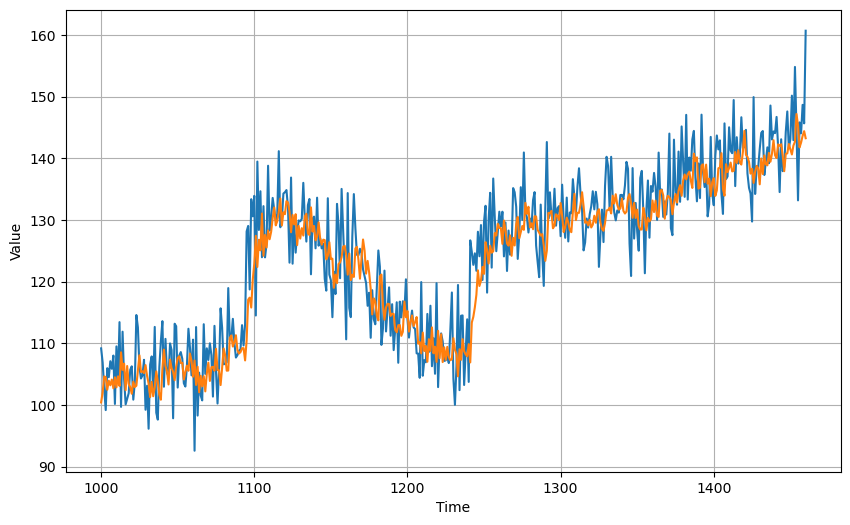

In [33]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [35]:
# MAEを計算する

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.6180496

In [36]:
# 10-5 学習率の調整
# tf.kerasは時間をかけて学習率を調整するのに役立つコールバックを用意
# 学習率パラメータを調整するのにコールバックを使う

# ここでは学習率を1e-8から始めて、エポックごとに少しずつ増やす。100回のエポックで学習率は約1e-3になる。

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

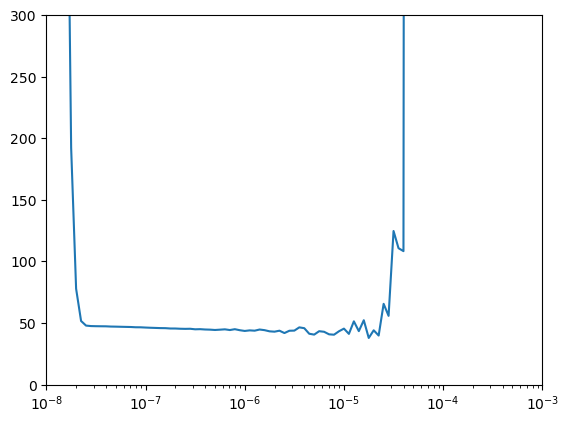

In [37]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

(1e-06, 0.0001, 0.0, 300.0)

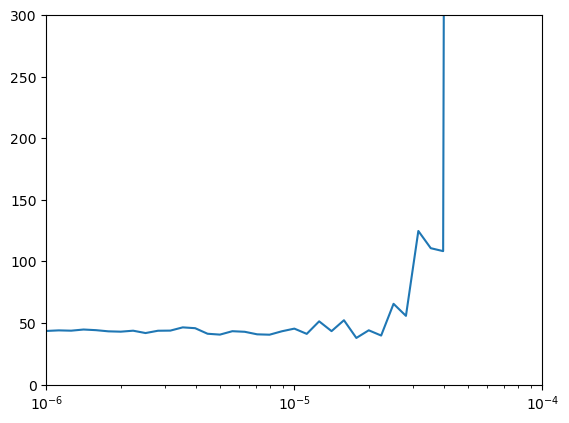

In [38]:
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-4, 0, 300])

In [39]:
window_size = 40
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
30/30 [==============================] - 1s 3ms/step - loss: 1245.6715
Epoch 2/500
30/30 [==============================] - 0s 4ms/step - loss: 123.4406
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 48.1795
Epoch 4/500
30/30 [==============================] - 0s 5ms/step - loss: 45.1423
Epoch 5/500
30/30 [==============================] - 0s 3ms/step - loss: 58.1996
Epoch 6/500
30/30 [==============================] - 0s 3ms/step - loss: 54.7460
Epoch 7/500
30/30 [==============================] - 0s 2ms/step - loss: 49.0580
Epoch 8/500
30/30 [==============================] - 1s 5ms/step - loss: 45.0376
Epoch 9/500
30/30 [==============================] - 0s 5ms/step - loss: 43.0833
Epoch 10/500
30/30 [==============================] - 0s 3ms/step - loss: 44.4133
Epoch 11/500
30/30 [==============================] - 0s 2ms/step - loss: 41.7305
Epoch 12/500
30/30 [==============================] - 0s 2ms/step - loss: 40.7502
Epoch 13/500
30/30 [==

Epoch 101/500
30/30 [==============================] - 0s 2ms/step - loss: 34.0266
Epoch 102/500
30/30 [==============================] - 0s 2ms/step - loss: 33.7339
Epoch 103/500
30/30 [==============================] - 0s 3ms/step - loss: 38.0480
Epoch 104/500
30/30 [==============================] - 0s 2ms/step - loss: 33.2540
Epoch 105/500
30/30 [==============================] - 0s 2ms/step - loss: 39.3461
Epoch 106/500
30/30 [==============================] - 0s 2ms/step - loss: 34.2023
Epoch 107/500
30/30 [==============================] - 0s 1ms/step - loss: 33.3728
Epoch 108/500
30/30 [==============================] - 0s 2ms/step - loss: 42.2235
Epoch 109/500
30/30 [==============================] - 0s 2ms/step - loss: 34.6786
Epoch 110/500
30/30 [==============================] - 0s 2ms/step - loss: 40.6245
Epoch 111/500
30/30 [==============================] - 0s 2ms/step - loss: 40.9667
Epoch 112/500
30/30 [==============================] - 0s 2ms/step - loss: 37.3791
Epoc

30/30 [==============================] - 0s 2ms/step - loss: 36.9480
Epoch 200/500
30/30 [==============================] - 0s 1ms/step - loss: 36.7901
Epoch 201/500
30/30 [==============================] - 0s 2ms/step - loss: 34.6869
Epoch 202/500
30/30 [==============================] - 0s 2ms/step - loss: 37.6713
Epoch 203/500
30/30 [==============================] - 0s 2ms/step - loss: 33.6896
Epoch 204/500
30/30 [==============================] - 0s 2ms/step - loss: 35.5996
Epoch 205/500
30/30 [==============================] - 0s 2ms/step - loss: 43.1759
Epoch 206/500
30/30 [==============================] - 0s 2ms/step - loss: 33.8794
Epoch 207/500
30/30 [==============================] - 0s 2ms/step - loss: 33.2913
Epoch 208/500
30/30 [==============================] - 0s 2ms/step - loss: 33.9488
Epoch 209/500
30/30 [==============================] - 0s 2ms/step - loss: 39.3728
Epoch 210/500
30/30 [==============================] - 0s 2ms/step - loss: 39.7281
Epoch 211/500
30/3

30/30 [==============================] - 0s 2ms/step - loss: 43.3115
Epoch 298/500
30/30 [==============================] - 0s 1ms/step - loss: 35.1701
Epoch 299/500
30/30 [==============================] - 0s 1ms/step - loss: 32.5326
Epoch 300/500
30/30 [==============================] - 0s 2ms/step - loss: 43.8562
Epoch 301/500
30/30 [==============================] - 0s 2ms/step - loss: 33.3165
Epoch 302/500
30/30 [==============================] - 0s 2ms/step - loss: 39.0816
Epoch 303/500
30/30 [==============================] - 0s 2ms/step - loss: 35.0301
Epoch 304/500
30/30 [==============================] - 0s 2ms/step - loss: 36.7164
Epoch 305/500
30/30 [==============================] - 0s 2ms/step - loss: 43.7553
Epoch 306/500
30/30 [==============================] - 0s 1ms/step - loss: 35.6146
Epoch 307/500
30/30 [==============================] - 0s 2ms/step - loss: 38.4188
Epoch 308/500
30/30 [==============================] - 0s 2ms/step - loss: 45.3577
Epoch 309/500
30/3

30/30 [==============================] - 0s 2ms/step - loss: 34.1854
Epoch 396/500
30/30 [==============================] - 0s 2ms/step - loss: 37.9291
Epoch 397/500
30/30 [==============================] - 0s 2ms/step - loss: 36.0265
Epoch 398/500
30/30 [==============================] - 0s 2ms/step - loss: 38.6868
Epoch 399/500
30/30 [==============================] - 0s 2ms/step - loss: 40.0854
Epoch 400/500
30/30 [==============================] - 0s 3ms/step - loss: 33.8138
Epoch 401/500
30/30 [==============================] - 0s 2ms/step - loss: 33.8053
Epoch 402/500
30/30 [==============================] - 0s 2ms/step - loss: 34.3973
Epoch 403/500
30/30 [==============================] - 0s 2ms/step - loss: 34.7938
Epoch 404/500
30/30 [==============================] - 0s 1ms/step - loss: 42.1497
Epoch 405/500
30/30 [==============================] - 0s 2ms/step - loss: 34.6145
Epoch 406/500
30/30 [==============================] - 0s 2ms/step - loss: 34.7192
Epoch 407/500
30/3

30/30 [==============================] - 0s 3ms/step - loss: 37.4507
Epoch 494/500
30/30 [==============================] - 0s 2ms/step - loss: 40.0395
Epoch 495/500
30/30 [==============================] - 0s 2ms/step - loss: 43.4669
Epoch 496/500
30/30 [==============================] - 0s 2ms/step - loss: 36.0400
Epoch 497/500
30/30 [==============================] - 0s 2ms/step - loss: 41.6583
Epoch 498/500
30/30 [==============================] - 0s 2ms/step - loss: 34.4183
Epoch 499/500
30/30 [==============================] - 0s 2ms/step - loss: 36.8092
Epoch 500/500
30/30 [==============================] - 0s 2ms/step - loss: 36.1692


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


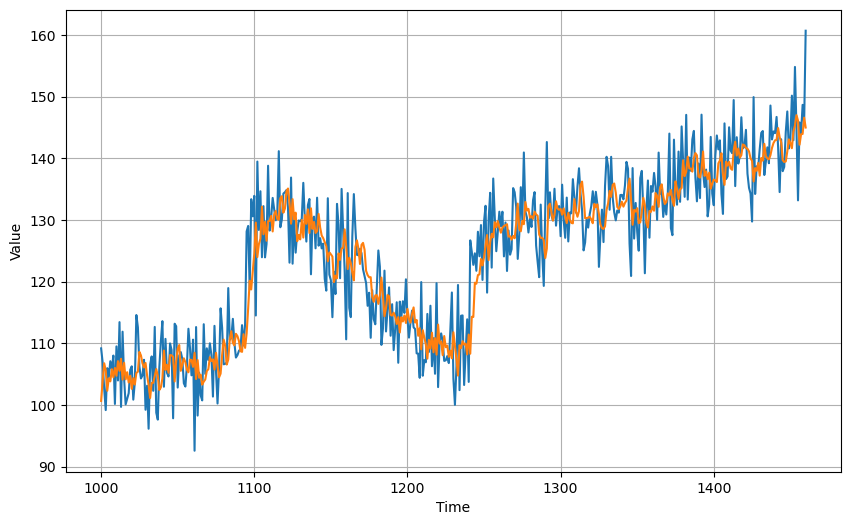

In [40]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.565499

In [42]:
# 11章 畳み込みと回帰によるシーケンスモデルの構築

In [43]:
# 畳み込みのコード化

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [44]:
# filters・・・学習させたいフィルタの数。この数のフィルタを生成し、データに会うように時間をかけて学習する。
# kernel_size・・・フィルタの大きさ。
# strides・・・フィルタがリストをスキャンする際のステップの大きさ。通常は1。
# padding・・・リストのどちらの端からデータをドロップするかを決定する。
# activatoin・・・活性化関数。reluは層から出てくる負の値を効果的に排除することを意味する。
# input_shape・・・ネットワークに渡す入力データの形状。ここでは最初の層のため指定する必要がある。

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Dense(28, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
30/30 [==============================] - 1s 6ms/step - loss: 767.3103
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 125.6799
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 113.9443
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 106.6623
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 100.4944
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 97.4744
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 95.8405
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 94.1105
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 92.4781
Epoch 10/100
30/30 [==============================] - 0s 4ms/step - loss: 92.1879
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 93.0014
Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 91.7871
Epoch 13/100
30/30 [

30/30 [==============================] - 0s 6ms/step - loss: 88.7635


45/45 [==============================] - 1s 8ms/step


4.713813

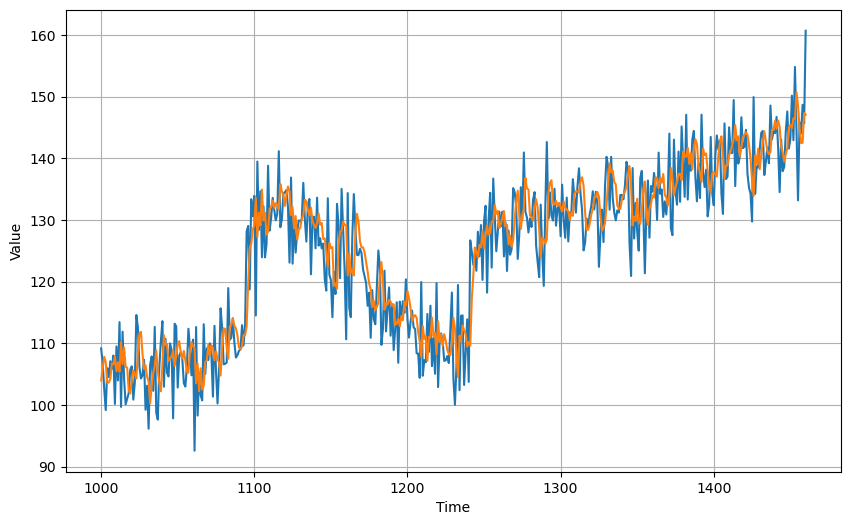

In [45]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, series[..., np.newaxis], window_size)
results = forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [46]:
# 11-2 NASA気象データ

In [51]:
def get_data():
    data_file = "動かして学ぶAI・機械学習の基礎/tmp/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series

In [52]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

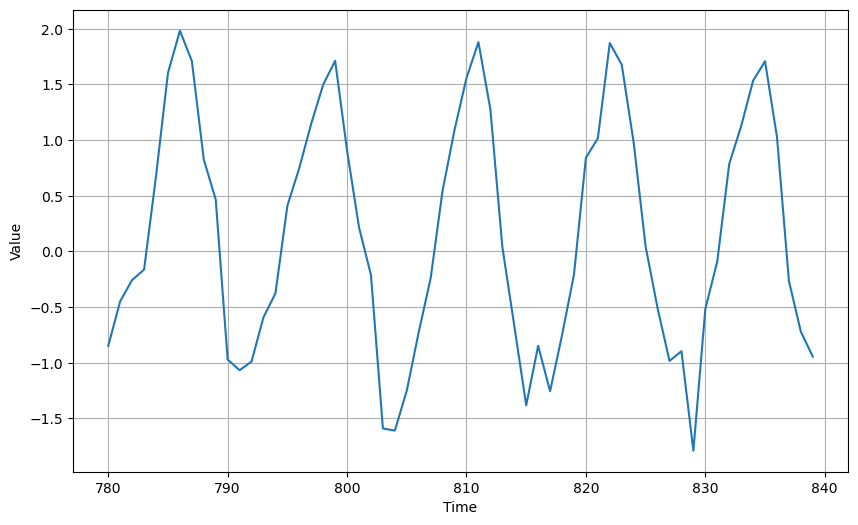

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [54]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [55]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, input_shape=[None, 1], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/100
38/38 [==============================] - 10s 62ms/step - loss: 0.4546 - mae: 0.8651 - val_loss: 0.5231 - val_mae: 0.9348
Epoch 2/100
38/38 [==============================] - 1s 20ms/step - loss: 0.4538 - mae: 0.8641 - val_loss: 0.5222 - val_mae: 0.9337
Epoch 3/100
38/38 [==============================] - 1s 18ms/step - loss: 0.4529 - mae: 0.8631 - val_loss: 0.5213 - val_mae: 0.9326
Epoch 4/100
38/38 [==============================] - 1s 18ms/step - loss: 0.4521 - mae: 0.8620 - val_loss: 0.5205 - val_mae: 0.9315
Epoch 5/100
38/38 [==============================] - 1s 19ms/step - loss: 0.4512 - mae: 0.8610 - val_loss: 0.5196 - val_mae: 0.9305
Epoch 6/100
38/38 [==============================] - 1s 20ms/step - loss: 0.4504 - mae: 0.8600 - val_loss: 0.5188 - val_mae: 0.9294
Epoch 7/100
38/38 [==============================] - 1s 21ms/step - loss: 0.4496 - mae: 0.8590 - val_loss: 0.5179 - val_mae: 0.9283
Epoch 8/100
38/38 [==============================] - 1s 19ms/step - loss: 0

38/38 [==============================] - 1s 18ms/step - loss: 0.4045 - mae: 0.8044 - val_loss: 0.4706 - val_mae: 0.8705
Epoch 63/100
38/38 [==============================] - 1s 17ms/step - loss: 0.4037 - mae: 0.8034 - val_loss: 0.4697 - val_mae: 0.8694
Epoch 64/100
38/38 [==============================] - 1s 21ms/step - loss: 0.4028 - mae: 0.8023 - val_loss: 0.4688 - val_mae: 0.8683
Epoch 65/100
38/38 [==============================] - 1s 19ms/step - loss: 0.4020 - mae: 0.8013 - val_loss: 0.4679 - val_mae: 0.8672
Epoch 66/100
38/38 [==============================] - 1s 17ms/step - loss: 0.4011 - mae: 0.8003 - val_loss: 0.4670 - val_mae: 0.8661
Epoch 67/100
38/38 [==============================] - 1s 17ms/step - loss: 0.4003 - mae: 0.7993 - val_loss: 0.4661 - val_mae: 0.8650
Epoch 68/100
38/38 [==============================] - 1s 18ms/step - loss: 0.3994 - mae: 0.7982 - val_loss: 0.4652 - val_mae: 0.8639
Epoch 69/100
38/38 [==============================] - 1s 19ms/step - loss: 0.3985 

In [56]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [58]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 2s 30ms/step


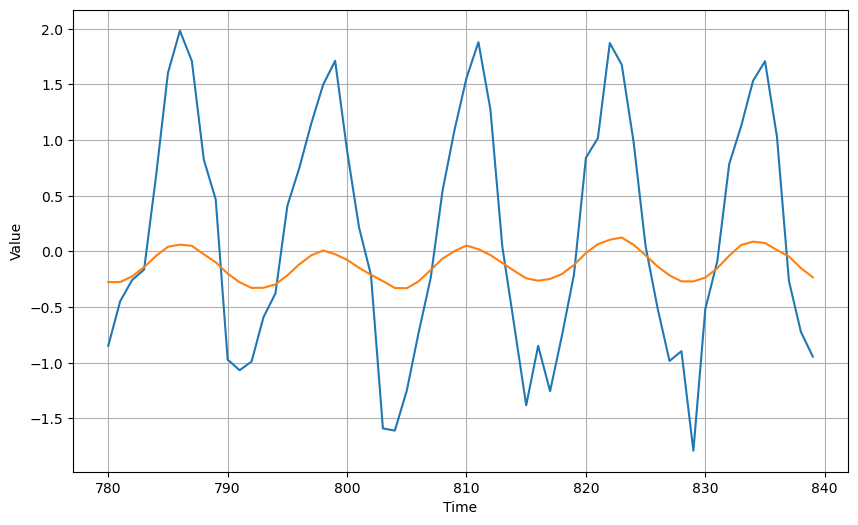

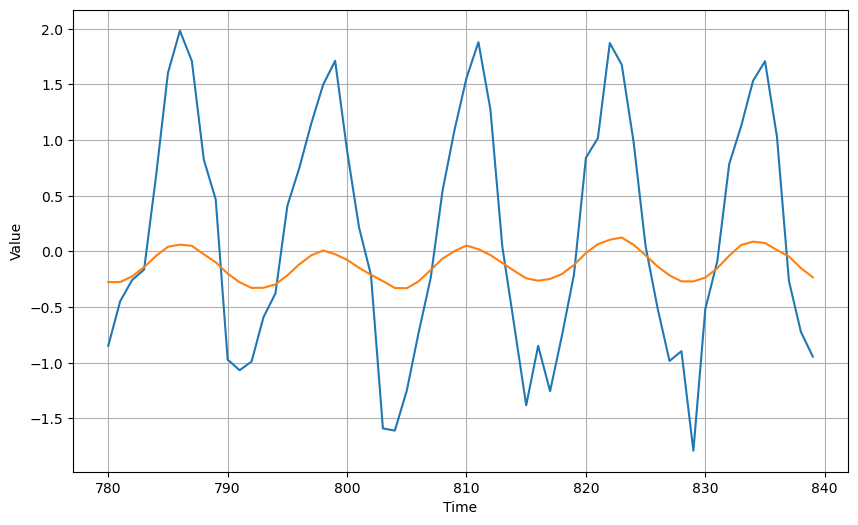

In [59]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [60]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.8264501


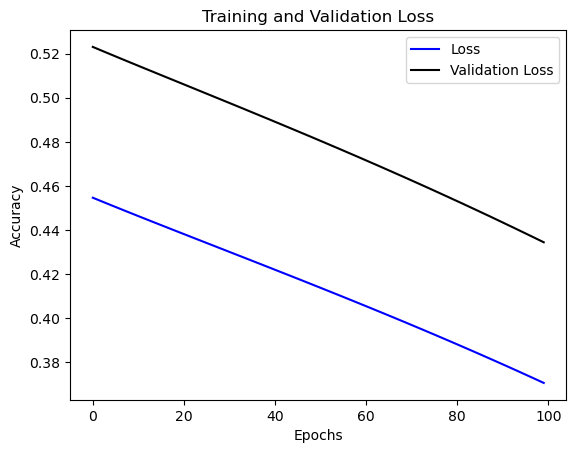

<Figure size 640x480 with 0 Axes>

In [61]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [62]:
# 11-3 シーケンスモデルにRNNを使用する

In [63]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

min = np.min(series)
max = np.max(series)
series -= min
series /= max
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

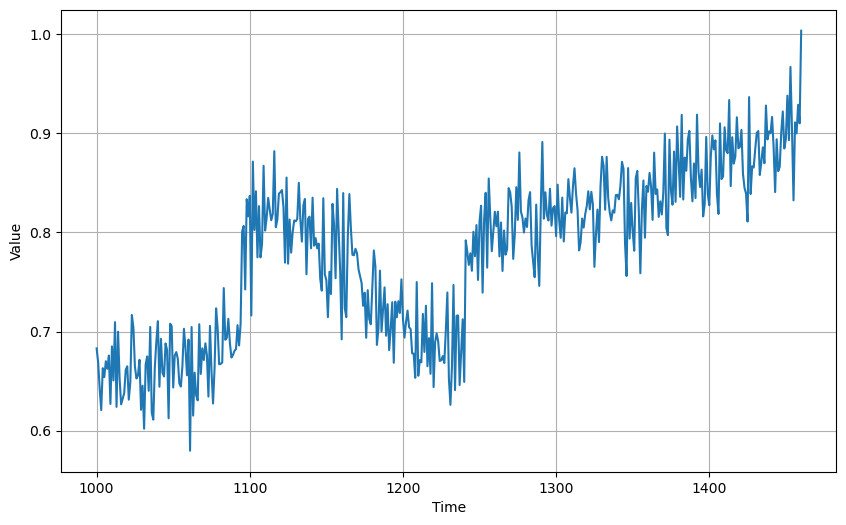

In [64]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [66]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.5, activation='relu'), 
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1)

Epoch 1/100
31/31 [==============================] - 3s 10ms/step - loss: 0.2744 - mae: 0.2744
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.1645 - mae: 0.1645
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1320 - mae: 0.1320
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1134 - mae: 0.1134
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0990 - mae: 0.0990
Epoch 6/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0863 - mae: 0.0863
Epoch 7/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0773 - mae: 0.0773
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0695 - mae: 0.0695
Epoch 9/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0646 - mae: 0.0646
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0577 - mae: 0.0577
Epoch 11/100
31/31 [==============================]

31/31 [==============================] - 0s 10ms/step - loss: 0.0396 - mae: 0.0396
Epoch 87/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0397 - mae: 0.0397
Epoch 88/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0390 - mae: 0.0390
Epoch 89/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0395 - mae: 0.0395
Epoch 90/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0405 - mae: 0.0405
Epoch 91/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0396 - mae: 0.0396
Epoch 92/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0401 - mae: 0.0401
Epoch 93/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0399 - mae: 0.0399
Epoch 94/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0393 - mae: 0.0393
Epoch 95/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0392 - mae: 0.0392
Epoch 96/100
31/31 [==============================] - 0s 1

In [67]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [68]:
forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

15/15 [==============================] - 0s 6ms/step


160.70773


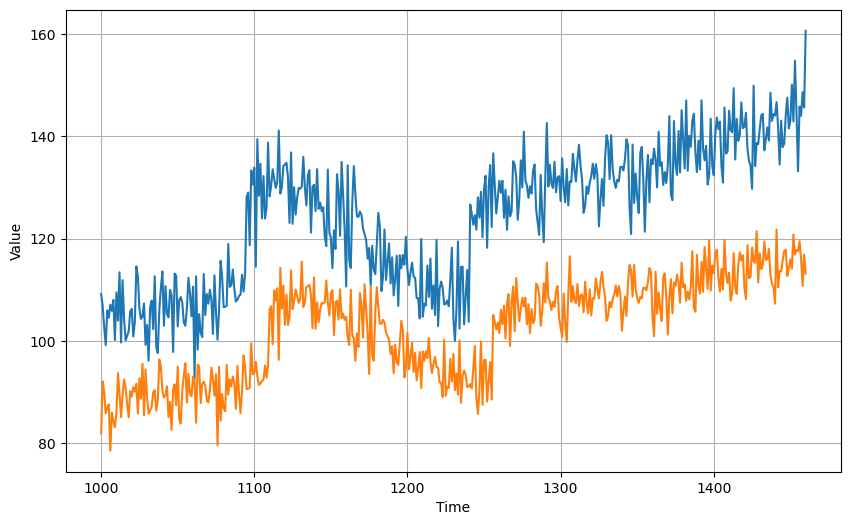

In [69]:
plt.figure(figsize=(10, 6))

#plot_series(time_valid, x_valid)
#plot_series(time_valid, forecast)

scaled_xvalid=x_valid*max
scaled_xvalid=scaled_xvalid+min
scaled_forecast=forecast*max
scaled_forecast=scaled_forecast+min

plot_series(time_valid, scaled_xvalid)
plot_series(time_valid, scaled_forecast)

print(max)

In [70]:
tf.keras.metrics.mean_absolute_error(scaled_xvalid, scaled_forecast).numpy()

array([42.516277 , 32.319366 , 34.520813 , 38.584114 , 37.589104 ,
       36.846123 , 45.927452 , 38.469124 , 40.084217 , 41.305576 ,
       38.435818 , 30.749477 , 34.85803  , 39.374706 , 34.99879  ,
       31.976313 , 33.639854 , 36.75909  , 39.388206 , 34.29374  ,
       35.327133 , 33.483704 , 34.362465 , 32.820045 , 38.63101  ,
       31.746445 , 35.735706 , 28.914572 , 38.99199  , 30.028358 ,
       35.509895 , 38.67948  , 37.986485 , 37.308647 , 34.48197  ,
       34.07737  , 38.100628 , 35.95706  , 28.085127 , 29.521286 ,
       34.11783  , 35.491417 , 35.13652  , 33.317932 , 39.348217 ,
       36.382835 , 41.820858 , 33.871777 , 32.92116  , 37.008762 ,
       29.472433 , 39.71347  , 40.603436 , 34.166786 , 31.146473 ,
       28.800665 , 36.507713 , 30.866262 , 34.82831  , 35.250744 ,
       31.400532 , 32.17836  , 40.433197 , 29.100218 , 29.390934 ,
       36.60955  , 32.823517 , 32.41192  , 33.198654 , 36.085693 ,
       36.486748 , 34.059113 , 29.68531  , 31.891815 , 35.1193

In [71]:
#11-5 ドロップアウトの使用

In [72]:
def get_data():
    data_file = "動かして学ぶAI・機械学習の基礎/tmp/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series

In [73]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [74]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

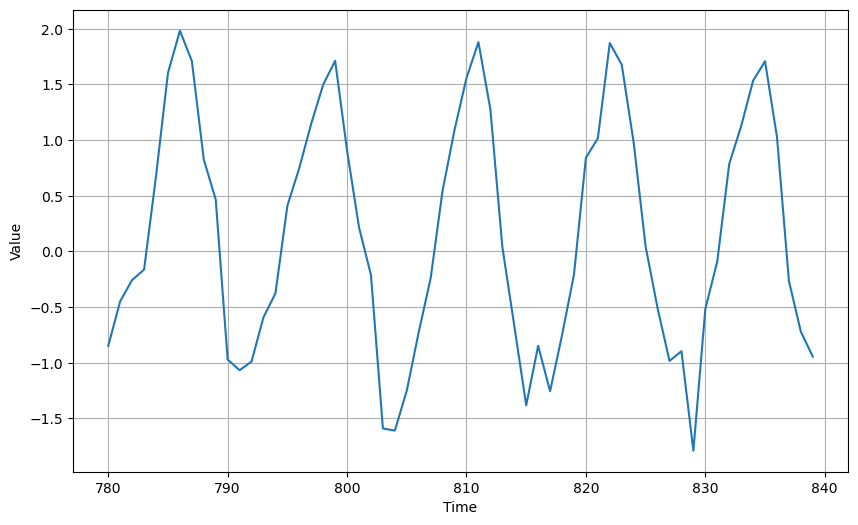

In [75]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [76]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [78]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
  tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/100
38/38 [==============================] - 5s 49ms/step - loss: 0.4595 - mae: 0.8724 - val_loss: 0.5260 - val_mae: 0.9445
Epoch 2/100
38/38 [==============================] - 2s 42ms/step - loss: 0.4573 - mae: 0.8690 - val_loss: 0.5245 - val_mae: 0.9425
Epoch 3/100
38/38 [==============================] - 2s 47ms/step - loss: 0.4576 - mae: 0.8693 - val_loss: 0.5230 - val_mae: 0.9405
Epoch 4/100
38/38 [==============================] - 1s 37ms/step - loss: 0.4545 - mae: 0.8658 - val_loss: 0.5215 - val_mae: 0.9384
Epoch 5/100
38/38 [==============================] - 2s 42ms/step - loss: 0.4541 - mae: 0.8652 - val_loss: 0.5200 - val_mae: 0.9364
Epoch 6/100
38/38 [==============================] - 2s 39ms/step - loss: 0.4521 - mae: 0.8631 - val_loss: 0.5185 - val_mae: 0.9344
Epoch 7/100
38/38 [==============================] - 1s 37ms/step - loss: 0.4511 - mae: 0.8615 - val_loss: 0.5170 - val_mae: 0.9324
Epoch 8/100
38/38 [==============================] - 2s 42ms/step - loss: 0.

38/38 [==============================] - 2s 44ms/step - loss: 0.3769 - mae: 0.7723 - val_loss: 0.4353 - val_mae: 0.8294
Epoch 63/100
38/38 [==============================] - 3s 76ms/step - loss: 0.3736 - mae: 0.7683 - val_loss: 0.4337 - val_mae: 0.8275
Epoch 64/100
38/38 [==============================] - 3s 68ms/step - loss: 0.3737 - mae: 0.7685 - val_loss: 0.4320 - val_mae: 0.8256
Epoch 65/100
38/38 [==============================] - 2s 43ms/step - loss: 0.3717 - mae: 0.7656 - val_loss: 0.4304 - val_mae: 0.8237
Epoch 66/100
38/38 [==============================] - 2s 40ms/step - loss: 0.3708 - mae: 0.7660 - val_loss: 0.4288 - val_mae: 0.8219
Epoch 67/100
38/38 [==============================] - 2s 46ms/step - loss: 0.3703 - mae: 0.7648 - val_loss: 0.4272 - val_mae: 0.8200
Epoch 68/100
38/38 [==============================] - 2s 40ms/step - loss: 0.3664 - mae: 0.7590 - val_loss: 0.4255 - val_mae: 0.8182
Epoch 69/100
38/38 [==============================] - 2s 63ms/step - loss: 0.3666 

In [79]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [80]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 102ms/step


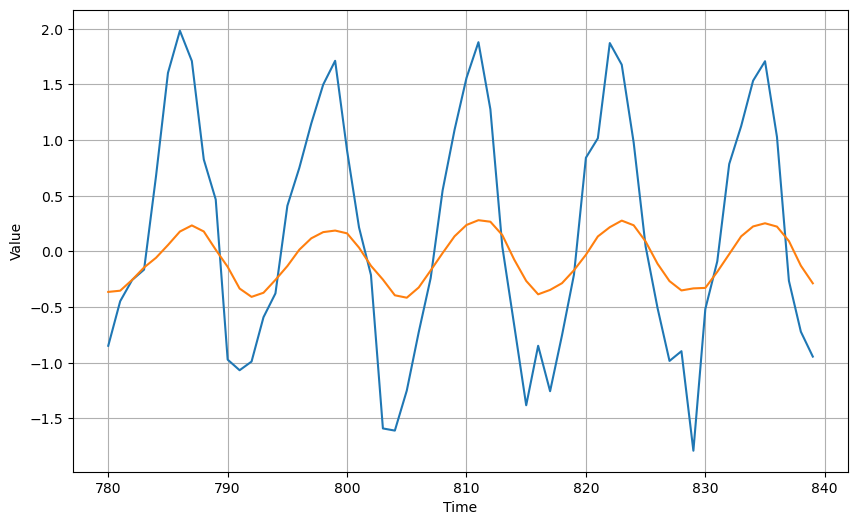

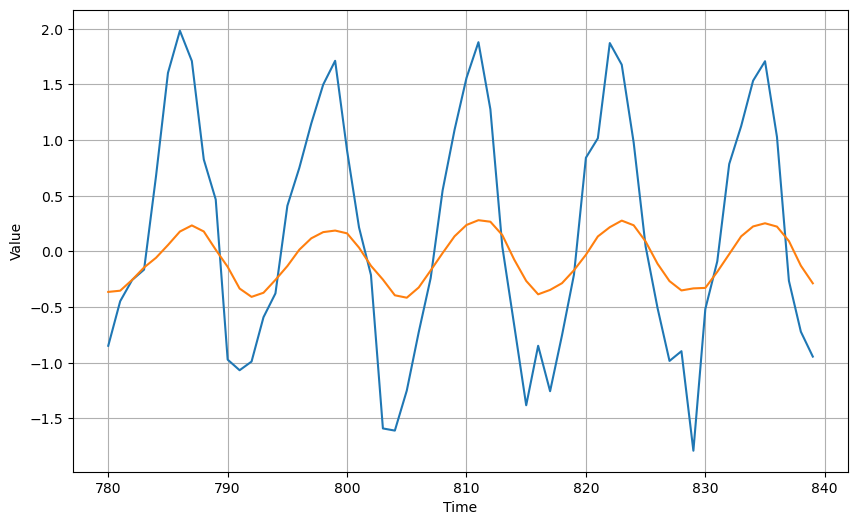

In [81]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()

In [82]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.74824977


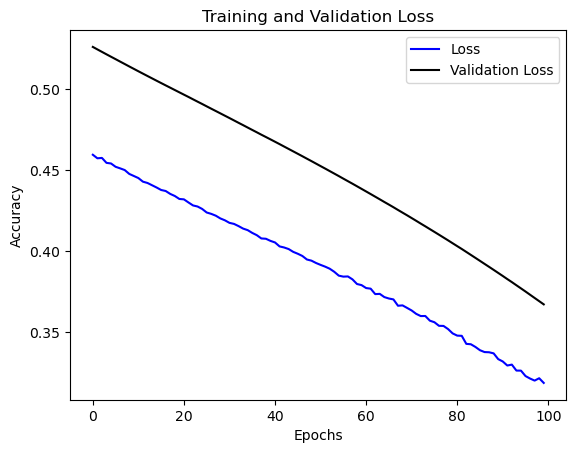

<Figure size 640x480 with 0 Axes>

In [83]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [84]:
# 11-6 双方向RNNの使用

In [88]:
def get_data():
    data_file = "動かして学ぶAI・機械学習の基礎/tmp/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")   
    return time, series

In [89]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [90]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

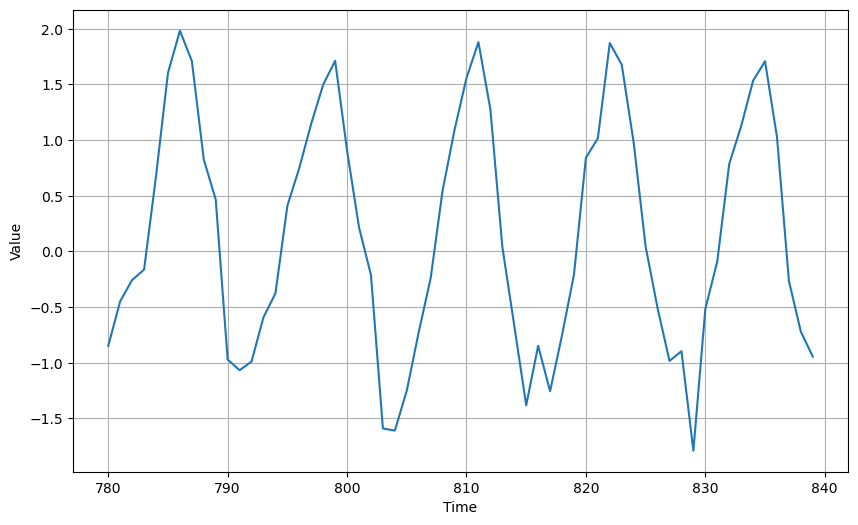

In [91]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [92]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [93]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/100
37/37 [==============================] - 21s 269ms/step - loss: 0.4499 - mae: 0.8590 - val_loss: 0.5288 - val_mae: 0.9583
Epoch 2/100
37/37 [==============================] - 7s 178ms/step - loss: 0.4468 - mae: 0.8554 - val_loss: 0.5266 - val_mae: 0.9560
Epoch 3/100
37/37 [==============================] - 10s 285ms/step - loss: 0.4458 - mae: 0.8539 - val_loss: 0.5245 - val_mae: 0.9538
Epoch 4/100
37/37 [==============================] - 8s 219ms/step - loss: 0.4425 - mae: 0.8505 - val_loss: 0.5223 - val_mae: 0.9515
Epoch 5/100
37/37 [==============================] - 5s 143ms/step - loss: 0.4398 - mae: 0.8471 - val_loss: 0.5201 - val_mae: 0.9493
Epoch 6/100
37/37 [==============================] - 5s 146ms/step - loss: 0.4380 - mae: 0.8448 - val_loss: 0.5180 - val_mae: 0.9470
Epoch 7/100
37/37 [==============================] - 6s 151ms/step - loss: 0.4371 - mae: 0.8438 - val_loss: 0.5158 - val_mae: 0.9447
Epoch 8/100
37/37 [==============================] - 6s 163ms/step 

Epoch 62/100
37/37 [==============================] - 11s 299ms/step - loss: 0.3319 - mae: 0.7195 - val_loss: 0.3966 - val_mae: 0.8212
Epoch 63/100
37/37 [==============================] - 11s 300ms/step - loss: 0.3305 - mae: 0.7163 - val_loss: 0.3944 - val_mae: 0.8187
Epoch 64/100
37/37 [==============================] - 16s 421ms/step - loss: 0.3262 - mae: 0.7124 - val_loss: 0.3921 - val_mae: 0.8161
Epoch 65/100
37/37 [==============================] - 13s 354ms/step - loss: 0.3246 - mae: 0.7096 - val_loss: 0.3898 - val_mae: 0.8135
Epoch 66/100
37/37 [==============================] - 12s 319ms/step - loss: 0.3222 - mae: 0.7072 - val_loss: 0.3876 - val_mae: 0.8109
Epoch 67/100
37/37 [==============================] - 11s 308ms/step - loss: 0.3198 - mae: 0.7041 - val_loss: 0.3853 - val_mae: 0.8082
Epoch 68/100
37/37 [==============================] - 12s 327ms/step - loss: 0.3203 - mae: 0.7042 - val_loss: 0.3831 - val_mae: 0.8056
Epoch 69/100
37/37 [==============================] - 1

In [94]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [95]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 2s 279ms/step


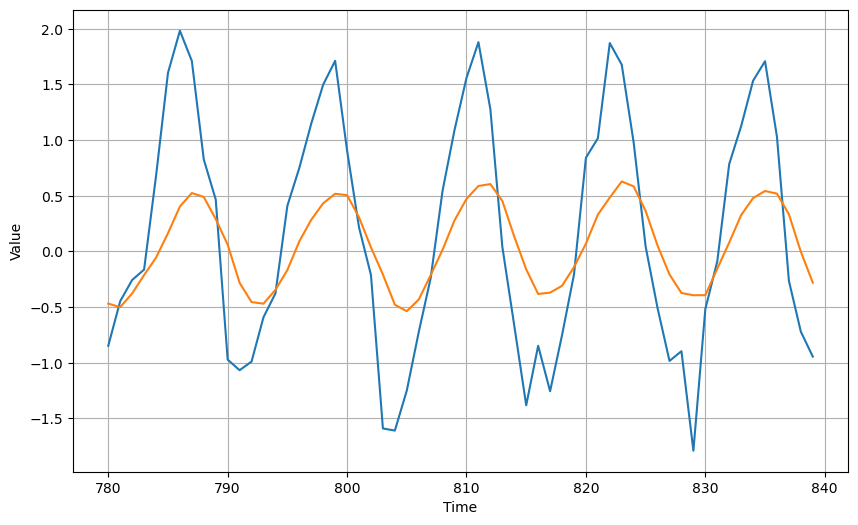

In [96]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

In [97]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.6695231


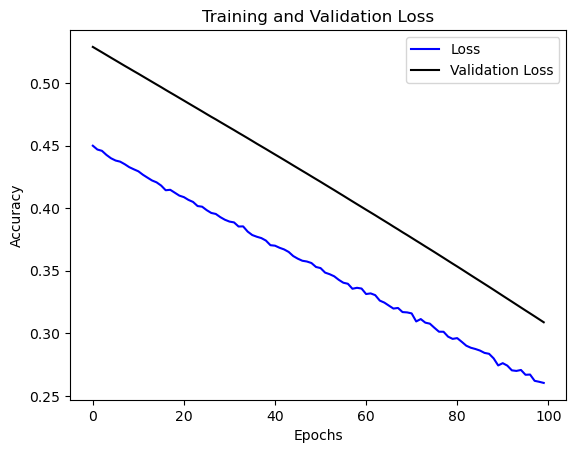

<Figure size 640x480 with 0 Axes>

In [98]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()